In [1]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import FunctionTransformer as FT

from lib.Extractor import FeatureExtractor
from lib.Models import FullyConnectedNetworkClassifier
from lib.Datasets import TabularDataset
from lib.Transformers import NumericalTransformer, CategoricalTransformer, CategoricalTargetTransformer, DatasetTransformer
from utils.utils import load_dataset

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

In [2]:
print(sklearn.__version__), print(np.__version__)

0.23.2
1.19.1


(None, None)

##### Reproducibility

In [3]:
torch.manual_seed(0)
np.random.seed(0)

### Whole training set

In [4]:
whole_train_df = pd.read_csv('train.csv.gz', compression='gzip', header=0, sep=',', error_bad_lines=False, low_memory=False)
print('{0:,} registros a las {1}'.format(len(whole_train_df), datetime.now()))
whole_train_df.head()

180,761 registros a las 2020-09-12 21:19:05.479396


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


In [5]:
whole_train_df['conversion'].value_counts()

False    164017
True      16744
Name: conversion, dtype: int64

### Training and Validation set's split

In [6]:
train_data = []
validation_data = []

for row in whole_train_df.itertuples(index=False):
    if abs(hash(row.item_id)) % 10 < 2: 
        validation_data.append(row)
    else:
        train_data.append(row)
        
train_df = pd.DataFrame(data=train_data, columns=whole_train_df.columns)
validation_df = pd.DataFrame(data=validation_data, columns=whole_train_df.columns)

In [7]:
print('{0:,} registros a las {1}'.format(len(train_df), datetime.now()))
train_df.head()

143,072 registros a las 2020-09-12 21:19:09.571848


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
3,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días
4,True,82,174.367607,495.326667,2030.839333,5.659401,21.715447,28.544715,0.001,False,...,2671.0,94577.0,17.0,3511.0,2006125,612,81237,c6874fdd-aabd-495a-9632-b651b0ffac87,32266680.0,Garantía de fábrica: 2 meses


In [8]:
print('{0:,} registros a las {1}'.format(len(validation_df), datetime.now()))
validation_df.head()

37,689 registros a las 2020-09-12 21:19:09.599230


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
1,True,60,454.653574,421.946805,9817.295667,5.227991,5.654728,7.488539,0.000,False,...,3947.0,7253.0,49.0,5227.0,270671,1873,229152,f651be12-d9c5-4e29-b77e-8e95b5137af3,498004001.0,6 meses de garantía.
2,True,44,114.704700,200.589045,2239.911000,4.387991,2.588060,3.023881,0.001,False,...,867.0,5279.0,4.0,1013.0,336447,243,202158,ede61a11-5ef8-4626-86d0-2040abcb15d3,NaN,NaN
3,True,201,35.620699,39.111875,20.859667,2.107527,3.062500,4.312500,0.001,False,...,49.0,419.0,9.0,69.0,37832,1391,6031,236b8125-4b99-4e82-b2ff-1d3a306e1a66,222834358.0,Sin garantía
4,True,206,40.526875,52.671250,28.091333,2.462500,3.062500,4.062500,0.001,False,...,49.0,636.0,13.0,65.0,29690,946,3790,4bec55c3-21d4-408c-a2dd-dd58ceb38f08,186474264.0,Sin garantía


### Test set

In [9]:
test_df = pd.read_csv('test.csv', sep=',')
print('{0:,} registros a las {1}'.format(len(test_df), datetime.now()))
test_df.head()

19,211 registros a las 2020-09-12 21:19:09.815613


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,4,98.426510,91.979648,3657.724000,3.589443,3.461023,4.988265,0.001,False,...,1364.0,18.0,5951.0,40954,300,100477,703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7,233223201.0,Garantia de fabrica,0
1,True,12,242.485208,821.376944,985.652333,3.215580,26.222222,28.388889,0.001,False,...,3724.0,41.0,1022.0,135133,926,44033,d714e65e-5447-4f7d-9a4e-aaa57efa6107,337881137.0,NaN,1
2,True,5,2450.533424,1365.504354,33454.856667,7.097276,14.646259,15.217687,0.001,False,...,1839.0,71.0,11185.0,204788,8457,716157,299cb623-b71c-4f9d-b792-48d5744f0449,86609353.0,Garantía de fábrica: 12 meses,2
3,True,9052,157.735448,78.692131,160.007333,4.927390,2.983607,3.524590,0.001,False,...,85528.0,44.0,215.0,1404477,1907,6580,f2060244-f0da-43db-91b7-4c1bb5f99e67,430797570.0,Sin garantía,3
4,True,37,116.891454,163.245653,4043.050667,2.937837,7.257066,19.771198,0.001,False,...,61466.0,274.0,14690.0,1466424,2633,215184,d7f3b7f4-a9fa-4bd8-a600-3f2714480779,6566243.0,Garantía de fábrica: 6 meses,4


In [10]:
X_test = test_df.to_dict('records')
X_test[:2]

[{'accepts_mercadopago': True,
  'available_quantity': 4,
  'avg_gmv_item_domain_30days': 98.42651,
  'avg_gmv_item_sel': 91.979648,
  'avg_gmv_seller_bday': 3657.724,
  'avg_qty_orders_item_domain_30days': 3.5894428152492672,
  'avg_qty_orders_item_sel_30days': 3.4610226320201174,
  'avg_si_item_sel_30day': 4.988265,
  'benefit': 0.001,
  'boosted': False,
  'category_id': 'MLA29933',
  'date': '2020-04-10',
  'deal_print_id': '13486cc0-7b38-11ea-80da-b7bc289f1eb3',
  'domain_id': 'MLA-HEATING_PADS',
  'etl_version': '0.0.1',
  'free_shipping': False,
  'fulfillment': False,
  'full_name': 'Salud y Equipamiento Médico -> Cuidado de la Salud -> Terapias de Frío y Calor -> Almohadillas Térmicas',
  'health': 0.66,
  'is_pdp': False,
  'product_id': nan,
  'item_id': 'MLA687322333',
  'listing_type_id': 'gold_special',
  'logistic_type': 'cross_docking',
  'main_picture': 'http://mla-s2-p.mlstatic.com/989963-MLA31846949555_082019-O.jpg',
  'offset': 528,
  'original_price': 2000,
  'plat

### Loading with helper function

In [11]:
#X_train, X_validation, Y_train, Y_validation = load_dataset()
X_train = train_df.to_dict('records')
X_validation = validation_df.to_dict('records')
X_test = test_df.to_dict('records')

Y_train = train_df['conversion'].values
Y_validation = validation_df['conversion'].values

In [12]:
X_train[:2]

[{'accepts_mercadopago': True,
  'available_quantity': 59,
  'avg_gmv_item_domain_30days': 938.031376,
  'avg_gmv_item_sel': 2153.933091,
  'avg_gmv_seller_bday': 135195.200333,
  'avg_qty_orders_item_domain_30days': 3.4305625,
  'avg_qty_orders_item_sel_30days': 12.407859798194373,
  'avg_si_item_sel_30day': 13.69145,
  'benefit': 0.001,
  'boosted': False,
  'category_id': 'MLA1055',
  'conversion': False,
  'date': '2020-03-06',
  'deal_print_id': 'a9cb2270-5f61-11ea-89fc-13e674cbfad4',
  'domain_id': 'MLA-CELLPHONES',
  'etl_version': '0.0.1',
  'free_shipping': True,
  'fulfillment': False,
  'full_name': 'Celulares y Teléfonos -> Celulares y Smartphones',
  'health': 0.0,
  'is_pdp': False,
  'product_id': 15183595.0,
  'item_id': 'MLA830939055',
  'listing_type_id': 'gold_special',
  'logistic_type': 'cross_docking',
  'main_picture': nan,
  'offset': 0,
  'original_price': 29999,
  'platform': '/web/desktop',
  'price': 20999,
  'print_position': 1717,
  'print_server_timestamp

In [13]:
np.array(list(map(lambda record: record['total_visits_item'], X_train[:10])), dtype=object)

array([543, 1789, 7473, 416, 612, 7453, 5132, 4524, 17921, 21528],
      dtype=object)

In [14]:
string_arr = np.array([True, True, False, np.nan], dtype=object)
string_arr

array([True, True, False, nan], dtype=object)

In [15]:
float_arr = string_arr.astype(np.str)
float_arr

array(['True', 'True', 'False', 'nan'], dtype='<U5')

### Selected features

In [16]:
numerical_features = [
    'available_quantity',
    'avg_gmv_item_sel',
    'avg_qty_orders_item_domain_30days',
    'avg_qty_orders_item_sel_30days',
    'health', 
    'sold_quantity',
    'total_asp_item_domain_30days',
    'total_asp_item_sel_30days',
    'total_gmv_domain_bday',
    'total_gmv_item_30days',
    'total_items_seller',
    'total_orders_domain_30days',
    'total_orders_item_30days',
    'total_orders_sel_30days',  
]

categorical_features = [
    'free_shipping',
    'is_pdp',
    
    # Categoricals
    'category_id',
    'deal_print_id',
    'domain_id',
    'product_id',
    'item_id',
    'listing_type_id',
    'logistic_type',
    'platform',
    'tags',
    'uid',
    'user_id',
    'offset',  
    'print_position',
]

date_features = ['date']
new_categorical_features = ['day_of_week', 'is_weekend']
target_column = ['conversion']

In [17]:
len(numerical_features), len(categorical_features), len(date_features), len(numerical_features+categorical_features+new_categorical_features)

(14, 15, 1, 31)

### Dataset's features subsetings

### Transformations

#### Feature extractions

In [18]:
def get_day_of_week(feature:np.ndarray) -> np.ndarray:
    dates = [datetime.strptime(str_date, '%Y-%m-%d') for str_date in feature]
    return np.array([str(dt.weekday()+1) for dt in dates], dtype=object)

def is_weekend(feature:np.ndarray) -> np.ndarray:
    dates = [datetime.strptime(str_date, '%Y-%m-%d') for str_date in feature]
    return np.array(['0' if dt.weekday() >= 0 and dt.weekday() <= 4 else '1' for dt in dates], dtype=np.object)

In [19]:
# Year, Month, Day, Day of the week, Is weekend
#print_date_ft_extractor = FeatureExtractor(decompose_print_date)
#_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([train_df['date'].to_numpy()])
#X_train = np.hstack((X_train, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
#X_train[:3,:], X_train.shape

In [20]:
#_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([validation_df['date'].to_numpy()])
#X_validation = np.hstack((X_validation, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
#X_validation[:3,:], X_validation.shape

In [21]:
#_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([test_df['date'].to_numpy()])
#X_test = np.hstack((X_test, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
#X_test[:3,:], X_test.shape

In [22]:
#feature_tms = CategoricalTransformer(force_casting=True)
#feature_tms = CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args), FT(transform_tags)])
#feature_tms = CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)
#tranformed_train = feature_tms.fit_transform(X_train[:,12])
#len(feature_tms.encoder.classes_)

In [23]:
#feature_tms.transform(X_validation[:,12])
#len(feature_tms.encoder.classes_)

#### Functions

In [24]:
def transform_tags(feature:np.ndarray) -> np.ndarray:
    tms_1 = [value[1:-1] for value in feature]
    tms_2 = [sorted(value.split(', ')) for value in tms_1]
    tms_3 = [' '.join(value) for value in tms_2]
    return np.array(tms_3, dtype=object) 

In [25]:
dataset_tranformer = DatasetTransformer([
    # Categorical features - Boolean
    ('free_shipping', CategoricalTransformer('free_shipping')),
    ('is_pdp', CategoricalTransformer('is_pdp')),
    # Categorical features
    ('category_id', CategoricalTransformer('category_id')),
    ('deal_print_id', CategoricalTransformer('deal_print_id')),
    ('domain_id', CategoricalTransformer('domain_id')),
    ('product_id', CategoricalTransformer('product_id')),
    ('item_id', CategoricalTransformer('item_id')),
    ('listing_type_id', CategoricalTransformer('listing_type_id')),
    ('logistic_type', CategoricalTransformer('logistic_type')),
    ('platform', CategoricalTransformer('platform')),
    ('tags', CategoricalTransformer(feature='tags', pre_tms=[FT(transform_tags)])),
    ('uid', CategoricalTransformer('uid')),
    ('user_id', CategoricalTransformer('user_id')),
    ('offset', CategoricalTransformer('offset')),
    ('print_position', CategoricalTransformer('print_position')),
    # Categorical Features extracted from "date"
    ('day_of_week', CategoricalTransformer(feature='date', pre_tms=[FT(get_day_of_week)])),
    ('is_weekend', CategoricalTransformer(feature='date', pre_tms=[FT(is_weekend)])),
    
    # Numerical features
    ('available_quantity', NumericalTransformer('available_quantity')),
    ('avg_gmv_item_sel', NumericalTransformer('avg_gmv_item_sel')),
    ('avg_qty_orders_item_domain_30days', NumericalTransformer('avg_qty_orders_item_domain_30days')),
    ('avg_qty_orders_item_sel_30days', NumericalTransformer('avg_qty_orders_item_sel_30days')),
    ('health', NumericalTransformer('health')),
    ('sold_quantity', NumericalTransformer('sold_quantity')),
    ('total_asp_item_domain_30days', NumericalTransformer('total_asp_item_domain_30days')),
    ('total_asp_item_sel_30days', NumericalTransformer('total_asp_item_sel_30days')),
    ('total_gmv_domain_bday', NumericalTransformer('total_gmv_domain_bday')),
    ('total_gmv_item_30days', NumericalTransformer('total_gmv_item_30days')),
    ('total_items_seller', NumericalTransformer('total_items_seller')),
    ('total_orders_domain_30days', NumericalTransformer('total_orders_domain_30days')),
    ('total_orders_item_30days', NumericalTransformer('total_orders_item_30days')),
    ('total_orders_sel_30days', NumericalTransformer('total_orders_sel_30days'))
])

target_transformer = CategoricalTargetTransformer('conversion')

In [26]:
%%time
numerical_features_train, categorical_features_train = dataset_tranformer.fit_transform(X_train)
target_train = target_transformer.fit_transform(Y_train)

CPU times: user 7.05 s, sys: 408 ms, total: 7.45 s
Wall time: 7.46 s


In [27]:
numerical_features_train.shape, categorical_features_train.shape, target_train.shape

((143072, 14), (143072, 17), (143072, 1))

In [28]:
numerical_features_train[:10,1].squeeze(), numerical_features_train[:,1].shape

(array([ 0.26768434, -0.21190022, -0.18871243, -0.03254   , -0.14799243,
        -0.22626288, -0.21842838, -0.11496574,  0.5019387 , -0.17790767]),
 (143072,))

In [29]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
t1 = SimpleImputer().fit_transform(train_df['avg_gmv_item_sel'].values.reshape(-1,1))
scaler = StandardScaler()
t1 = scaler.fit_transform(t1)
t1[:10,0].squeeze(), t1[:,0].squeeze().shape

(array([ 0.26768434, -0.21190022, -0.18871243, -0.03254   , -0.14799243,
        -0.22626288, -0.21842838, -0.11496574,  0.5019387 , -0.17790767]),
 (143072,))

In [30]:
_, tms = dataset_tranformer.get_feature('avg_gmv_item_sel')
tms.scaler.mean_, tms.scaler.var_

(array([1085.83645223]), array([15921177.31068242]))

In [31]:
scaler.mean_, scaler.var_

(array([1085.83645223]), array([15921177.31068242]))

In [32]:
label_enconder = LabelEncoder()
t2 = label_enconder.fit_transform(train_df['category_id'])
t2[:10], label_enconder.classes_[:10]

(array([  45,  562,  652,  234,  463, 1116,   77, 1764, 1765, 1957]),
 array(['MLA10005', 'MLA1002', 'MLA10059', 'MLA10060', 'MLA10061',
        'MLA10063', 'MLA10064', 'MLA10066', 'MLA10067', 'MLA10068'],
       dtype=object))

In [33]:
_, tms = dataset_tranformer.get_feature('category_id')
tms.encoder.classes_[:10]

array(['MLA10005', 'MLA1002', 'MLA10059', 'MLA10060', 'MLA10061',
       'MLA10063', 'MLA10064', 'MLA10066', 'MLA10067', 'MLA10068'],
      dtype='<U9')

In [34]:
categorical_features_train[:10,2]

array([  45,  562,  652,  234,  463, 1116,   77, 1764, 1765, 1957])

In [35]:
np.all(categorical_features_train[:,2] == t2)

True

In [36]:
np.all(numerical_features_train[:,0].squeeze() == t1[:,0].squeeze())

False

In [37]:
diff = np.setdiff1d(numerical_features_train[:,1].squeeze(), t1[:,0].squeeze())

In [38]:
train_df.isna().sum()

accepts_mercadopago                       0
available_quantity                        0
avg_gmv_item_domain_30days             3218
avg_gmv_item_sel                       3218
avg_gmv_seller_bday                    3218
avg_qty_orders_item_domain_30days      3218
avg_qty_orders_item_sel_30days         3218
avg_si_item_sel_30day                  3218
benefit                                   1
boosted                                   0
category_id                               0
conversion                                0
date                                      0
deal_print_id                             0
domain_id                                 0
etl_version                               0
free_shipping                             0
fulfillment                               0
full_name                                 0
health                                    0
is_pdp                                64675
product_id                           108175
item_id                         

In [39]:
%%time
numerical_features_validation, categorical_features_validation = dataset_tranformer.transform(X_validation)
target_validation = target_transformer.transform(Y_validation)

free_shipping
unique_values: 2
diff: 0
self.encoder.classes_: 2
is_pdp
unique_values: 3
diff: 0
self.encoder.classes_: 3
category_id
unique_values: 1168
diff: 158
self.encoder.classes_: 2198
deal_print_id
unique_values: 37335
diff: 36912
self.encoder.classes_: 177948
domain_id
unique_values: 961
diff: 112
self.encoder.classes_: 1693
product_id
unique_values: 1010
diff: 634
self.encoder.classes_: 4079
item_id
unique_values: 5021
diff: 5021
self.encoder.classes_: 24962
listing_type_id
unique_values: 2
diff: 0
self.encoder.classes_: 2
logistic_type
unique_values: 7
diff: 0
self.encoder.classes_: 7
platform
unique_values: 4
diff: 0
self.encoder.classes_: 4
tags
unique_values: 198
diff: 24
self.encoder.classes_: 316
uid
unique_values: 35499
diff: 27033
self.encoder.classes_: 147059
user_id
unique_values: 31445
diff: 23160
self.encoder.classes_: 128045
offset
unique_values: 159
diff: 1
self.encoder.classes_: 208
print_position
unique_values: 5491
diff: 717
self.encoder.classes_: 10633
day_of

In [40]:
numerical_features_validation.shape, categorical_features_validation.shape, target_validation.shape

((37689, 14), (37689, 17), (37689, 1))

In [41]:
len(train_df['deal_print_id'].unique()), len(validation_df['deal_print_id'].unique())

(141036, 37335)

In [42]:
#%%time
#diff = np.setdiff1d(validation_df['deal_print_id'].unique(), train_df['deal_print_id'].unique(), True)
#len(diff)

KeyboardInterrupt: 

In [53]:
%%time
numerical_features_test, categorical_features_test = dataset_tranformer.transform(X_test)

free_shipping
unique_values: 2
diff: 0
self.encoder.classes_: 2
is_pdp
unique_values: 3
diff: 0
self.encoder.classes_: 3
category_id
unique_values: 880
diff: 0
self.encoder.classes_: 2284
deal_print_id
unique_values: 19057
diff: 0
self.encoder.classes_: 196744
domain_id
unique_values: 744
diff: 0
self.encoder.classes_: 1742
product_id
unique_values: 611
diff: 0
self.encoder.classes_: 4441
item_id
unique_values: 2733
diff: 0
self.encoder.classes_: 27695
listing_type_id
unique_values: 2
diff: 0
self.encoder.classes_: 2
logistic_type
unique_values: 6
diff: 0
self.encoder.classes_: 7
platform
unique_values: 4
diff: 0
self.encoder.classes_: 4
tags
unique_values: 129
diff: 0
self.encoder.classes_: 324
uid
unique_values: 18453
diff: 0
self.encoder.classes_: 159996
user_id
unique_values: 16404
diff: 0
self.encoder.classes_: 139111
offset
unique_values: 143
diff: 0
self.encoder.classes_: 209
print_position
unique_values: 3981
diff: 0
self.encoder.classes_: 10902
day_of_week
unique_values: 7
dif

In [74]:
numerical_features_test.shape, categorical_features_test.shape

((19211, 14), (19211, 17))

### Datasets and Dataloaders

In [54]:
train_ds = TabularDataset(numerical_features_train, categorical_features_train, target_train)
validation_ds = TabularDataset(numerical_features_validation, categorical_features_validation, target_validation)
test_ds = TabularDataset(numerical_features_test, categorical_features_test)

In [55]:
for i in range(1):
    x_numerical, x_categorical, y = train_ds[i]
    print(f'{i} -> x_numerical: {x_numerical.shape}, X_categorical: {x_categorical.shape} Y: {y}')

0 -> x_numerical: torch.Size([14]), X_categorical: torch.Size([17]) Y: tensor([0.])


In [56]:
for i in range(1):
    x_numerical, x_categorical, y = validation_ds[i]
    print(f'{i} -> x_numerical: {x_numerical.shape}, X_categorical: {x_categorical.shape} Y: {y}')

0 -> x_numerical: torch.Size([14]), X_categorical: torch.Size([17]) Y: tensor([0.])


In [57]:
for i in range(1):
    x_numerical, x_categorical, y = test_ds[i]
    print(f'{i} -> x_numerical: {x_numerical.shape}, X_categorical: {x_categorical.shape} Y: {y}')

0 -> x_numerical: torch.Size([14]), X_categorical: torch.Size([17]) Y: nan


In [58]:
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

train_dl_for_prediction = DataLoader(train_ds, batch_size=1024, shuffle=False)
validation_dl = DataLoader(validation_ds, batch_size=1024, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1024, shuffle=False)

In [49]:
#for x_numerical, x_categorical, y in train_dl:
#    print(f'{x_numerical.shape}, {x_categorical.shape}, {y.shape}')

### Training the network

In [59]:
embedding_dims = []
for feature in categorical_features + new_categorical_features:
    _, feature_tms = dataset_tranformer.get_feature(feature)
    #print(feature_tms)
    q_unique_values = len(feature_tms.encoder.classes_)
    embedding_size = min(q_unique_values//2, 50)
    mapping = (q_unique_values, embedding_size)
    embedding_dims.append(mapping)

embedding_dims

[(2, 1),
 (3, 1),
 (2284, 50),
 (196744, 50),
 (1742, 50),
 (4441, 50),
 (27695, 50),
 (2, 1),
 (7, 3),
 (4, 2),
 (324, 50),
 (159996, 50),
 (139111, 50),
 (209, 50),
 (10902, 50),
 (7, 3),
 (2, 1)]

In [60]:
model = FullyConnectedNetworkClassifier(
    q_numerical_features = len(numerical_features), 
    q_categorical_features = len(categorical_features + new_categorical_features),
    hidden_layers_size=[1024,512,128,64],
    embedding_dims=embedding_dims
)
optimizer = Adam(model.parameters(), lr=1e-1)
lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.97)
bceloss_fn = nn.BCELoss(reduction='mean')
epochs=3

In [61]:
model

FullyConnectedNetworkClassifier(
  (embeddings_layer): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 1)
    (2): Embedding(2284, 50)
    (3): Embedding(196744, 50)
    (4): Embedding(1742, 50)
    (5): Embedding(4441, 50)
    (6): Embedding(27695, 50)
    (7): Embedding(2, 1)
    (8): Embedding(7, 3)
    (9): Embedding(4, 2)
    (10): Embedding(324, 50)
    (11): Embedding(159996, 50)
    (12): Embedding(139111, 50)
    (13): Embedding(209, 50)
    (14): Embedding(10902, 50)
    (15): Embedding(7, 3)
    (16): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer_0): Sequential(
    (0): Linear(in_features=526, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNor

In [62]:
%%time
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=bceloss_fn, opt=optimizer, scheduler=lr_scheduler)

CPU times: user 8min 57s, sys: 34.6 s, total: 9min 31s
Wall time: 2min 41s


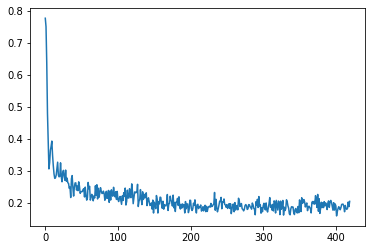

In [63]:
plt.plot(range(len(losses)), losses)

### Validating the net

In [64]:
x_numerical_train, x_categorical_train, y_train = train_ds.reverse_transform()

In [65]:
x_numerical_val, x_categorical_val, y_val = validation_ds.reverse_transform()

In [66]:
x_numerical_test, x_categorical_test, _ = test_ds.reverse_transform()

In [67]:
y_train_pred = model.predict(train_dl_for_prediction).numpy().squeeze()

In [68]:
y_val_pred = model.predict(validation_dl).numpy().squeeze()

In [69]:
y_test_pred = model.predict(test_dl).numpy().squeeze()

IndexError: index out of range in self

#### Training

In [70]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.9296664450367758


In [71]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.9235979087452472


#### Validation

In [72]:
aucroc_val = roc_auc_score(y_val, y_val_pred)
print(f'Auc Roc in test: {aucroc_val}')

Auc Roc in test: 0.8490117263768324


In [73]:
accuracy_val = accuracy_score(y_val, [1 if pred >= .5 else 0 for pred in y_val_pred])
print(f'Accuracy in test: {accuracy_val}')

Accuracy in test: 0.8999973467059355


#### Testing submission

In [51]:
y_test_pred[:5]

array([0.00653152, 0.00143854, 0.24205764, 0.00068901, 0.26798746],
      dtype=float32)

In [52]:
submission = pd.DataFrame({
    'conversion': y_test_pred
}).reset_index().rename({'index':'ROW_ID'}, axis=1)
submission['conversion'] = np.round(submission['conversion'], 4)
submission.tail()

,ROW_ID,conversion
19206,19206,0.0473
19207,19207,0.0560
19208,19208,0.0039
19209,19209,0.0465
19210,19210,0.0013


In [53]:
submission.to_csv('submissions/submission.csv.gz', compression='gzip', index=False)